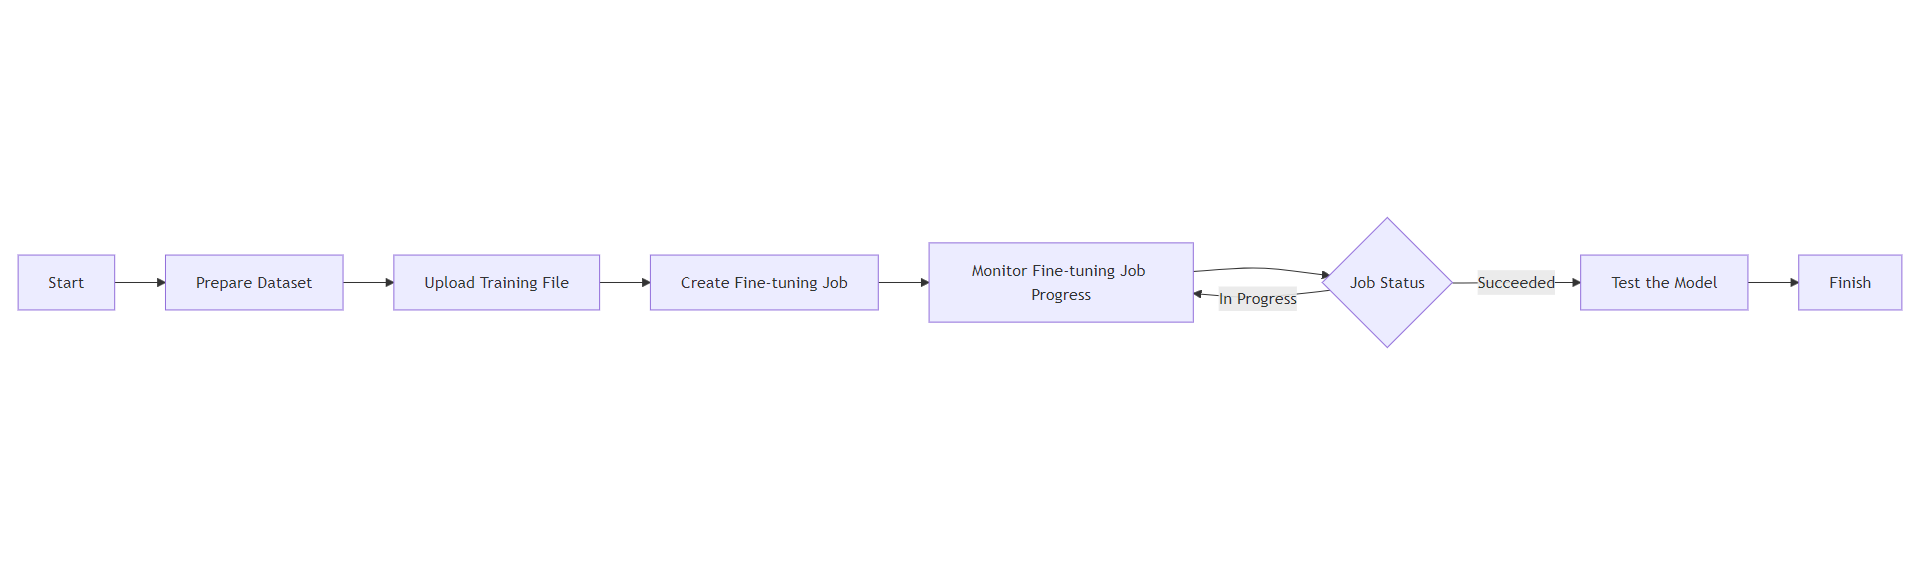

In [ ]:
from IPython.display import Image

# Displaying a local image (after uploading it to Colab)
Image(filename='/content/image.png')

In [ ]:
!pip install openai -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00


In [2]:
# prepare_data.py
import csv
import json

def convert_csv_to_training_format(input_csv, output_file):
    system_message = {
        "role": "system",
        "content": "Extract Details from medical report"
    }

    with open(input_csv, 'r', encoding='utf-8') as csvfile, \
         open(output_file, 'w', encoding='utf-8') as outfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header

        for row in reader:
            medical_report = row[0]
            extracted_json = row[1]

            training_example = {
                "messages": [
                    system_message,
                    {"role": "user", "content": medical_report},
                    {"role": "assistant", "content": extracted_json}
                ]
            }
            outfile.write(json.dumps(training_example) + '\n')


convert_csv_to_training_format("medical-records.csv", "training_data.jsonl")
convert_csv_to_training_format("validation-medical-records.csv", "validation_data.jsonl")
print("Training data prepared successfully!")

Training data prepared successfully!


In [ ]:
open_ai_key = ""

In [ ]:
import os
from openai import OpenAI
from time import sleep

# Initialize OpenAI client
client = OpenAI(api_key = open_ai_key)

In [ ]:
def upload_training_file(file_path):
    """Upload training file to OpenAI"""
    with open(file_path, "rb") as file:
        response = client.files.create(
            file=file,
            purpose="fine-tune"
        )
        return response.id

In [ ]:
training_file_id = upload_training_file("training_data.jsonl")
validation_file_id = upload_training_file("validation_data.jsonl")
training_file_id,validation_file_id

('file-ujcstKb2dnlqRfcUIoXZ07Xi', 'file-8TA40FNpb21BdnBMLo7dColE')

In [ ]:
def create_fine_tuning_job(training_file_id, validation_file_id=None, model="gpt-4o-mini-2024-07-18"):
    """Create a fine-tuning job"""
    response = client.fine_tuning.jobs.create(
        training_file=training_file_id,
        validation_file=validation_file_id,
        model=model
    )
    return response.id

In [ ]:
model="gpt-4o-mini-2024-07-18"
job_id = create_fine_tuning_job(training_file_id, validation_file_id, model)
job_id

'ftjob-ZwKI5ayinP749wFEUmjHCna4'

In [ ]:
def monitor_job(job_id):
    """Monitor fine-tuning job progress"""
    while True:
        job = client.fine_tuning.jobs.retrieve(job_id)
        print(f"Status: {job.status}")

        if job.status in ["succeeded", "failed"]:
            return job

        # List latest events
        events = client.fine_tuning.jobs.list_events(
            fine_tuning_job_id=job_id,
            limit=5
        )
        for event in events.data:
            print(f"Event: {event.message}")

        sleep(30)  # Check every 30 seconds

In [ ]:
job =  monitor_job(job_id)
if job.status == "succeeded":
  fine_tuned_model = job.fine_tuned_model
  print(f"Fine-tuned model ID: {fine_tuned_model}")
else:
  print("Fine-tuning failed.")

Status: running
Event: Fine-tuning job started
Event: Files validated, moving job to queued state
Event: Validating training file: file-ujcstKb2dnlqRfcUIoXZ07Xi and validation file: file-8TA40FNpb21BdnBMLo7dColE
Event: Created fine-tuning job: ftjob-ZwKI5ayinP749wFEUmjHCna4
Status: running
Event: Fine-tuning job started
Event: Files validated, moving job to queued state
Event: Validating training file: file-ujcstKb2dnlqRfcUIoXZ07Xi and validation file: file-8TA40FNpb21BdnBMLo7dColE
Event: Created fine-tuning job: ftjob-ZwKI5ayinP749wFEUmjHCna4
Status: running
Event: Fine-tuning job started
Event: Files validated, moving job to queued state
Event: Validating training file: file-ujcstKb2dnlqRfcUIoXZ07Xi and validation file: file-8TA40FNpb21BdnBMLo7dColE
Event: Created fine-tuning job: ftjob-ZwKI5ayinP749wFEUmjHCna4
Status: running
Event: Fine-tuning job started
Event: Files validated, moving job to queued state
Event: Validating training file: file-ujcstKb2dnlqRfcUIoXZ07Xi and validation

In [ ]:
def test_model(model_id, test_input):
    """Test the fine-tuned model"""
    completion = client.chat.completions.create(
        model=model_id,
        messages=[
            {
                "role": "system",
                "content": ""
            },
            {"role": "user", "content": test_input}
        ]
    )
    return completion.choices[0].message


In [ ]:
result = test_model(fine_tuned_model, "Marcus Wong, a 19-year-old male, presents with severe acne on face and upper back present for 1 year. Multiple inflammatory papules and nodules noted on examination. Previous trials of over-the-counter treatments ineffective. Started on Isotretinoin 40mg daily with monthly liver function monitoring.")
print(result)

ChatCompletionMessage(content='{"patient name": "Marcus Wong", "age": 19, "diagnosis": "severe acne", "prescribed medication": "Isotretinoin"}', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)


In [ ]:
result.content

'{"patient name": "Marcus Wong", "age": 19, "diagnosis": "severe acne", "prescribed medication": "Isotretinoin"}'

In [ ]:
import json
json.loads(result.content)

{'patient name': 'Marcus Wong',
 'age': 19,
 'diagnosis': 'severe acne',
 'prescribed medication': 'Isotretinoin'}